Class distribution:
 class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


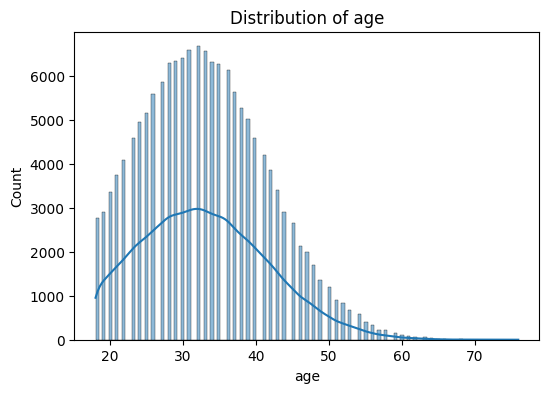

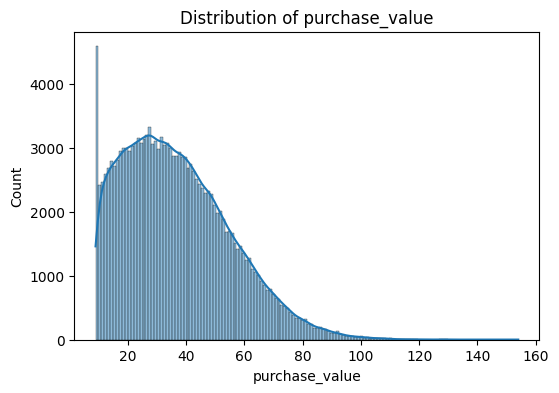

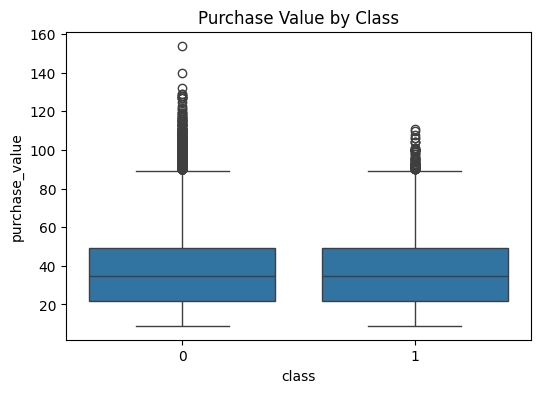

Country distribution:
 country
Public_or_Unknown                  0.516676
United States                      0.227957
China                              0.056362
Japan                              0.022824
United Kingdom                     0.020190
Korea Republic of                  0.016504
France                             0.014069
Germany                            0.013235
Canada                             0.008848
Italy                              0.008596
Russian Federation                 0.006982
India                              0.006532
Australia                          0.006068
Spain                              0.004996
Taiwan; Republic of China (ROC)    0.004811
Netherlands                        0.004209
Sweden                             0.003679
Poland                             0.003567
Indonesia                          0.003355
Viet Nam                           0.003031
Name: proportion, dtype: float64
Fraud patterns by country:
 class                       

In [1]:
# ===================================================
# Task 1: Data Analysis and Preprocessing 
# ===================================================

import pandas as pd
import numpy as np
import socket
import struct
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# ===================================================
# Step 1: Load Data
# ===================================================
fraud_df = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_df = pd.read_csv("../data/raw/IpAddress_to_Country.csv")

# ===================================================
# Step 2: Data Cleaning
# ===================================================
fraud_df.replace("", np.nan, inplace=True)
fraud_df.drop_duplicates(inplace=True)

# Impute numeric missing values
for col in ["age", "purchase_value"]:
    fraud_df[col] = fraud_df[col].fillna(fraud_df[col].median())

# Drop missing IPs
fraud_df.dropna(subset=["ip_address"], inplace=True)

# Correct data types
fraud_df["signup_time"] = pd.to_datetime(fraud_df["signup_time"])
fraud_df["purchase_time"] = pd.to_datetime(fraud_df["purchase_time"])
fraud_df["age"] = fraud_df["age"].astype(int)
fraud_df["purchase_value"] = fraud_df["purchase_value"].astype(float)

# ===================================================
# Step 3: EDA
# ===================================================
print("Class distribution:\n", fraud_df["class"].value_counts(normalize=True))

# Univariate: numeric
numeric_cols = ["age", "purchase_value"]
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(fraud_df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# Bivariate: purchase_value vs class
plt.figure(figsize=(6,4))
sns.boxplot(x="class", y="purchase_value", data=fraud_df)
plt.title("Purchase Value by Class")
plt.show()

# ===================================================
# Step 4: Geolocation Integration
# ===================================================
def ip_to_int_safe(ip):
    try:
        ip_float = float(ip)
        ip_int = int(ip_float)
        octet1 = (ip_int >> 24) & 255
        octet2 = (ip_int >> 16) & 255
        octet3 = (ip_int >> 8) & 255
        octet4 = ip_int & 255
        ip_str = f"{octet1}.{octet2}.{octet3}.{octet4}"
        return struct.unpack("!I", socket.inet_aton(ip_str))[0]
    except:
        return np.nan

fraud_df["ip_int"] = fraud_df["ip_address"].apply(ip_to_int_safe)
fraud_df.dropna(subset=["ip_int"], inplace=True)

ip_df["lower_bound_ip_address"] = ip_df["lower_bound_ip_address"].astype(int)
ip_df["upper_bound_ip_address"] = ip_df["upper_bound_ip_address"].astype(int)

def get_country(ip_int):
    match = ip_df[(ip_df["lower_bound_ip_address"] <= ip_int) &
                  (ip_df["upper_bound_ip_address"] >= ip_int)]
    if not match.empty:
        return match.iloc[0]["country"]
    else:
        return "Public_or_Unknown"

fraud_df["country"] = fraud_df["ip_int"].apply(get_country)

# Country distribution
print("Country distribution:\n", fraud_df["country"].value_counts(normalize=True).head(20))

# Fraud patterns by country
fraud_patterns = pd.crosstab(fraud_df["country"], fraud_df["class"], normalize="index")
print("Fraud patterns by country:\n", fraud_patterns.head(20))

# ===================================================
# Step 5: Feature Engineering
# ===================================================
fraud_df["user_txn_count"] = fraud_df.groupby("user_id")["purchase_time"].transform("count")
fraud_df["hour_of_day"] = fraud_df["purchase_time"].dt.hour
fraud_df["day_of_week"] = fraud_df["purchase_time"].dt.dayofweek
fraud_df["time_since_signup"] = (fraud_df["purchase_time"] - fraud_df["signup_time"]).dt.total_seconds()/3600

# ===================================================
# Step 6: Data Transformation (Memory Efficient)
# ===================================================
# Frequency encoding for high-cardinality features
for col in ["device_id", "ip_address"]:
    freq_encoding = fraud_df[col].value_counts(normalize=True)
    fraud_df[col + "_freq"] = fraud_df[col].map(freq_encoding)

# One-Hot Encode low-cardinality categorical features
low_card_cols = ["source", "browser", "sex", "country"]
fraud_df = pd.get_dummies(fraud_df, columns=low_card_cols, drop_first=True)

# Drop original string/object columns to avoid SMOTE errors
drop_cols = ["device_id", "ip_address", "signup_time", "purchase_time", "user_id", "ip_int"]
fraud_df_numeric = fraud_df.drop(columns=drop_cols)

# Standardize numeric features
num_cols = ["age", "purchase_value", "time_since_signup", "hour_of_day", "day_of_week", "user_txn_count",
            "device_id_freq", "ip_address_freq"]
scaler = StandardScaler()
fraud_df_numeric[num_cols] = scaler.fit_transform(fraud_df_numeric[num_cols])

# ===================================================
# Step 7: Handle Class Imbalance
# ===================================================
X = fraud_df_numeric.drop(columns=["class"])
y = fraud_df_numeric["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_res.value_counts())

# ===================================================
# Step 8: Save Cleaned & Processed Dataset
# ===================================================
fraud_df_numeric.to_csv("../data/processed/Fraud_Data_Processed.csv", index=False)
